# Feature Selection

Feature selection for XGBoost Regressor 

In [40]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt

from xgboost import XGBRegressor, plot_importance

from sklearn.feature_selection import RFE, SelectFromModel
from sklearn.model_selection import GridSearchCV
from matplotlib import pyplot

## Load Data 

In [ ]:
ds = pd.read_csv('./CW1_train.csv')
# Identify categorical columns
categorical_cols = ['cut', 'color', 'clarity']  # Replace with actual categorical column names

# One-hot encode categorical variables
ds = pd.get_dummies(ds, columns=categorical_cols, drop_first=True)

# Use complete dataset as K-fold cross-validation will be used 
X, y = ds.drop(columns='outcome'), ds['outcome']

For K-fold cross validation, K = 10 was chosen as a higher K value has generally resulted in [a model with a low bias and a modest variance](https://machinelearningmastery.com/k-fold-cross-validation/). This quote from [Applied Predicitve Modeling](http://amzn.to/2Fmrbib) is appropriate, "as k gets larger, the difference in size between the training set and the resmapling subsets gets smaller" and "as this difference decreases, the bias of the technique becomes smaller". I think a model will lower variance is better as it becomes more representative of how well it will perform on unseen data.  

In [ ]:
# Given an estimator model and a X_train split with selected features
# print out and store mean test and train R2 scores 
def feature_info(feat_dict, X, y, estimator):
    # As we are just using the basemodel no params specified yet 
    param = {}

    # K-fold cross-validation 
    gsearch = GridSearchCV(estimator = estimator, 
    param_grid = param, scoring='r2',n_jobs=4, cv=10, return_train_score=True)
    gsearch.fit(X, y)

    # Log information to console 
    print(f"number of feats: {X.shape[1]}")
    print(f"Features: {X.columns}")
    print(gsearch.best_params_, gsearch.best_score_, gsearch.scorer_)
    print(f"mean test score {(gsearch.cv_results_['mean_test_score'])}")
    print(f"mean train score {(gsearch.cv_results_['mean_train_score'])}")
    print(gsearch.cv_results_)
    print('\n')

    # Store information in given dictionary 
    feat_dict['featnum'].append(X.shape[1])
    feat_dict['mean_test_score'].append((gsearch.cv_results_['mean_test_score']))
    feat_dict['mean_train_score'].append((gsearch.cv_results_['mean_train_score']))
    
    return feat_dict


## Correlation 

Feature selection with pearson correlation. Pearson correlation was chosen, as observed from the EDA pearson and spearman correlation feature ranking did not differ. Performance did not differ a lot in regards to R2 score based on the feature subset. However, the highest performing subset chosen on how closely correlated it is to the feature outcome had 21 features. Those features were: 'depth', 'b3', 'b1', 'a1', 'a4', 'table', 'cut_Good', 'cut_Premium', 'cut_Very Good', 'cut_Ideal', 'z', 'clarity_SI1', 'color_G', 'color_J', 'color_E', 'color_H', 'x', 'clarity_VS1', 'price', 'y', 'clarity_IF'.

In [ ]:
# Retrieve correlation ranking 
correlations = ds.corr()
outcome_correlations = correlations['outcome']
outcome_correlations = (abs(outcome_correlations)).sort_values(ascending=False)

In [10]:
feat_dict = {'featnum': [], 'mean_test_score': [], 'mean_train_score': []}

# Iteratively fit n number of features to XGBoost to evaluate performance 
# n = 1 to 21 
for i in range (2, len(outcome_correlations)//2 + 1,1):
    X, y = ds.drop(columns='outcome'), ds['outcome']
    # Clean input data to only contain selected features 
    X = X[list(outcome_correlations[1:i].index)]

    # Conduct k-fold cross-validation on input data and log selected features and scores  
    feat_dict = feature_info(feat_dict, X, y, estimator=XGBRegressor())
    
corr_feat_df = pd.DataFrame(data=feat_dict)

number of feats: 1
Features: Index(['depth'], dtype='object')
{} 0.32200617356178185 make_scorer(r2_score, response_method='predict')
mean test score [0.32200617]
mean train score [0.34287062]
{'mean_fit_time': array([0.22450471]), 'std_fit_time': array([0.18330637]), 'mean_score_time': array([0.00541234]), 'std_score_time': array([0.00062411]), 'params': [{}], 'split0_test_score': array([0.3190845]), 'split1_test_score': array([0.35217356]), 'split2_test_score': array([0.30794967]), 'split3_test_score': array([0.33317391]), 'split4_test_score': array([0.32584335]), 'split5_test_score': array([0.363049]), 'split6_test_score': array([0.30143971]), 'split7_test_score': array([0.33358499]), 'split8_test_score': array([0.2500903]), 'split9_test_score': array([0.33367275]), 'mean_test_score': array([0.32200617]), 'std_test_score': array([0.02967355]), 'rank_test_score': array([1], dtype=int32), 'split0_train_score': array([0.34333366]), 'split1_train_score': array([0.33949867]), 'split2_tra

In [11]:
# Sort by which feature subset has the highest test score. 
corr_feat_df.sort_values(by="mean_test_score", ascending=False)

,featnum,mean_test_score,mean_train_score
20,21,[0.4019081823388107],[0.8180863260091937]
12,13,[0.3991797801098549],[0.8034873675423213]
19,20,[0.3989690060016563],[0.8188304349070537]
15,16,[0.3980343925880046],[0.8048942618104655]
14,15,[0.397585849776933],[0.8037478616656666]
4,5,[0.3966719329431325],[0.7736888894784801]
17,18,[0.39666960633472026],[0.8088414043715281]
7,8,[0.396306404339923],[0.7767270488955097]
16,17,[0.39542189775214687],[0.8066659635756539]
10,11,[0.39520924909167265],[0.7952093510329694]


## Recursive Feature Elimination 

Evaluating on feature subsets chosen through RFE instead of correlation, overall presented higher mean test scores on XGBoost. This indicates that it is slightly less underfitting than correlation feature selection, with an improvement of 0.0165 in the R2 score. With the highest performing subset having 10 features and containing features: 'depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'b9', 'cut_Ideal', 'color_G', 'color_H'. 

Going into more depth, feature selection was also evaluated against a dataset that had been cleaned of outliers, where every outlier was replaced with the mean value of the feature. This was an attempt to see if outlier cleaning had any affect on mean test score performance and the features selected. However the performance ranking and R2 scores for all features subset did not differ whether outliers were removed. This shows how robust XGBoost is. 

### Evaluation on Original Dataset

In [28]:
# Define the number of features we want 
n_feat_to_select = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17 ,20, 25]

# dictionary that maps the number of features to the features subset selected 
selected_sets = {}

X, y = ds.drop(columns='outcome'), ds['outcome']

# Find feature subsets 
for i in n_feat_to_select:
    model = XGBRegressor()
    rfe = RFE(model, n_features_to_select=i)  # Adjusts the number of features
    rfe.fit(X, y)

    # Display the Features selected
    selected_features = X.columns[rfe.support_]
    print("Selected Features:", selected_features, "\n")
    selected_sets[i] = list(selected_features)

print(selected_sets)

Selected Features: Index(['depth', 'a1', 'a4', 'b1', 'b3'], dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3'], dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'color_G'], dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'b9', 'color_G'], dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'b9', 'cut_Ideal', 'color_G'], dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'b9', 'cut_Ideal', 'color_G',
       'color_H'],
      dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b2', 'b3', 'b9', 'cut_Ideal',
       'color_G', 'color_H'],
      dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b2', 'b3', 'b9', 'b10', 'cut_Ideal',
       'color_G', 'color_H'],
      dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b2', 'b3', 'b8', 'b9', 'b10',
     

In [34]:
rfe_feat_dict = {'featnum': [], 'mean_test_score': [], 'mean_train_score': []}

# Fit each feature subset of XGBoost Regressor 
for i in n_feat_to_select:
    # Clean data to only contain features in the chosen subset 
    X, y = ds.drop(columns='outcome'), ds['outcome']
    X = X[selected_sets[i]]

    # Evaluate model performance and log information 
    rfe_feat_dict = feature_info(rfe_feat_dict, X, y, estimator=XGBRegressor())

rfe_feat_df = pd.DataFrame(data=rfe_feat_dict)

number of feats: 5
Features: Index(['depth', 'a1', 'a4', 'b1', 'b3'], dtype='object')
{} 0.3969009113210372 make_scorer(r2_score, response_method='predict')
mean test score [0.39690091]
mean train score [0.77368889]
{'mean_fit_time': array([0.25187747]), 'std_fit_time': array([0.06248154]), 'mean_score_time': array([0.0067055]), 'std_score_time': array([0.00134705]), 'params': [{}], 'split0_test_score': array([0.35870943]), 'split1_test_score': array([0.41076788]), 'split2_test_score': array([0.40936833]), 'split3_test_score': array([0.4030084]), 'split4_test_score': array([0.39294268]), 'split5_test_score': array([0.41934004]), 'split6_test_score': array([0.39304347]), 'split7_test_score': array([0.44648058]), 'split8_test_score': array([0.33461835]), 'split9_test_score': array([0.40072994]), 'mean_test_score': array([0.39690091]), 'std_test_score': array([0.0295459]), 'rank_test_score': array([1], dtype=int32), 'split0_train_score': array([0.77033787]), 'split1_train_score': array([0

In [35]:
# Display feature subset ranking based on highest mean test score 
rfe_feat_df.sort_values(by="mean_test_score", ascending=False)

,featnum,mean_test_score,mean_train_score
5,10,[0.41560972591807327],[0.8234897369647852]
2,7,[0.41059629599974273],[0.8069496402741798]
4,9,[0.41003390733917006],[0.8221279026119648]
9,14,[0.40956885011205724],[0.8608199801422021]
1,6,[0.40858944989278373],[0.8031095600985554]
3,8,[0.4072443268996285],[0.822200498845395]
8,13,[0.40559602075488355],[0.8530455302560291]
6,11,[0.40300265067645896],[0.8337392417179561]
14,25,[0.40182900275764855],[0.8944644956735962]
10,15,[0.40174237799190643],[0.867090873003398]


### Evaluation on Dataset Cleaned of Outliers 

In [64]:
ds_cleaned = ds.copy()

# function to be applyed to a dataframe column to remove outliers and replace them with Nan
def outliers(var):
    # List to store new feature values 
    transformed_var = []

    # lower quartile 
    q1 = ds_cleaned[var].quantile(.25)
    # upper quartile 
    q3 = ds_cleaned[var].quantile(.75)

    # IQR and outlier upperbound and lowerbound 
    iqr = q3-q1
    u_bound = float(q3+(1.5*iqr))
    l_bound = float(q1-(1.5*iqr))

    # If value is outlier replace with NaN 
    for i in ds_cleaned[var]:
        if i > u_bound:
            i = np.nan
        elif i < l_bound:
            i = np.nan
        else:
            i=i
        transformed_var.append(i)

    return transformed_var

# Clean for all Features that are have continous numerical values 
for col in ds_cleaned.select_dtypes(exclude=['object', 'bool']).columns:
    ds_cleaned[col] = outliers(col)

In [66]:
# Replace all Nan values with mean of feature 
for i in ds_cleaned.select_dtypes(exclude=['object', 'bool']).columns:
    ds_cleaned[i] = ds_cleaned[i].fillna(ds_cleaned[i].mean())

In [67]:
n_feat_to_select = [5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17 ,20, 25]
selected_sets = {}
X_cleaned, y_cleaned = ds_cleaned.drop(columns='outcome'), ds_cleaned['outcome']

for i in n_feat_to_select:
    model = XGBRegressor()
    rfe = RFE(model, n_features_to_select=i)  # Adjust the number of features
    rfe.fit(X_cleaned, y_cleaned)

    # Features selected
    selected_features = X_cleaned.columns[rfe.support_]
    print("Selected Features:", selected_features, "\n")
    selected_sets[i] = list(selected_features)

print(selected_sets)

Selected Features: Index(['depth', 'a1', 'a4', 'b1', 'b3'], dtype='object') 

Selected Features: Index(['depth', 'a1', 'a4', 'b1', 'b3', 'color_G'], dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'color_G'], dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'color_G', 'color_H'], dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'b10', 'color_G', 'color_H'], dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'b8', 'b10', 'color_G',
       'color_H'],
      dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'a10', 'b8', 'b10', 'color_G',
       'color_H'],
      dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'a10', 'b6', 'b8', 'b10',
       'color_G', 'color_H'],
      dtype='object') 

Selected Features: Index(['depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'a10', 'b6', 'b8', 'b9', 'b10',
      

In [68]:
cleaned_rfe_feat_dict = {'featnum': [], 'mean_test_score': [], 'mean_train_score': []}

# Train all selected feature subsets on baseline model to evaluate performance 
for i in n_feat_to_select:
    X_cleaned, y_cleaned = ds_cleaned.drop(columns='outcome'), ds_cleaned['outcome']
    X_cleaned = X_cleaned[selected_sets[i]]

    cleaned_rfe_feat_dict = feature_info(cleaned_rfe_feat_dict, X, y, estimator=XGBRegressor())

cleaned_rfe_feat_df = pd.DataFrame(data=cleaned_rfe_feat_dict)

number of feats: 25
Features: Index(['depth', 'a1', 'a3', 'a4', 'a5', 'b1', 'b2', 'b3', 'b4', 'b5', 'a6',
       'a7', 'a8', 'a9', 'a10', 'b6', 'b7', 'b8', 'b9', 'b10', 'cut_Ideal',
       'color_G', 'color_H', 'clarity_SI2', 'clarity_VVS1'],
      dtype='object')
{} 0.40182900275764855 make_scorer(r2_score, response_method='predict')
mean test score [0.401829]
mean train score [0.8944645]
{'mean_fit_time': array([0.90577221]), 'std_fit_time': array([0.21907263]), 'mean_score_time': array([0.01733379]), 'std_score_time': array([0.00330235]), 'params': [{}], 'split0_test_score': array([0.381675]), 'split1_test_score': array([0.39609682]), 'split2_test_score': array([0.40543569]), 'split3_test_score': array([0.38238974]), 'split4_test_score': array([0.41207397]), 'split5_test_score': array([0.44601442]), 'split6_test_score': array([0.39298917]), 'split7_test_score': array([0.44846141]), 'split8_test_score': array([0.34259876]), 'split9_test_score': array([0.41055504]), 'mean_test_score':

In [60]:
cleaned_rfe_feat_df.sort_values(by="mean_test_score", ascending=False)

,featnum,mean_test_score,mean_train_score
5,10,[0.41560972591807327],[0.8234897369647852]
2,7,[0.41059629599974273],[0.8069496402741798]
4,9,[0.41003390733917006],[0.8221279026119648]
9,14,[0.40956885011205724],[0.8608199801422021]
1,6,[0.40858944989278373],[0.8031095600985554]
3,8,[0.4072443268996285],[0.822200498845395]
8,13,[0.40559602075488355],[0.8530455302560291]
6,11,[0.40300265067645896],[0.8337392417179561]
14,25,[0.40182900275764855],[0.8944644956735962]
10,15,[0.40174237799190643],[0.867090873003398]


## XgBoost Feature Importance Feature Selection 

As XGBoost has build in feature importance, we could use XGBoost's feature importance values to limit and decide on the number of features that we would like to select. The feature importance is calculated for a single decision tree via the amount each attribute split improves the performance metric. Hence, it shows how much splitting on each feature allows the reduction of impurity across all splits. 

Based on the plotted feature importance graph, interestingly carat seems to be the one of the impactful attributes. This is interesting as on feature selection with correlation Carat was not a prominent feature at all. This is also correct for other selection processes I have tried, such as RFE. Though an [article](https://medium.com/towards-data-science/interpretable-machine-learning-with-xgboost-9ec80d148d27) written by Scott Lundberg, suggests that the feature importance function built into XGBoost can be unreliable for a tree model. Further experimentation on the types of feature importance measures (weight, cover and gain) in XGBoost, all provided very different orderings; highlighting it's inconsistency.

Overall, XGBoost feature importance feature selection performed marginally better than RFE by 0.000810115. With the mean highest test R2 score of 0.41619835 utilising 8 features, which are: 'depth', 'a1', 'a3', 'a4', 'b1', 'b3', 'cut_Ideal' and 'color_G'. 

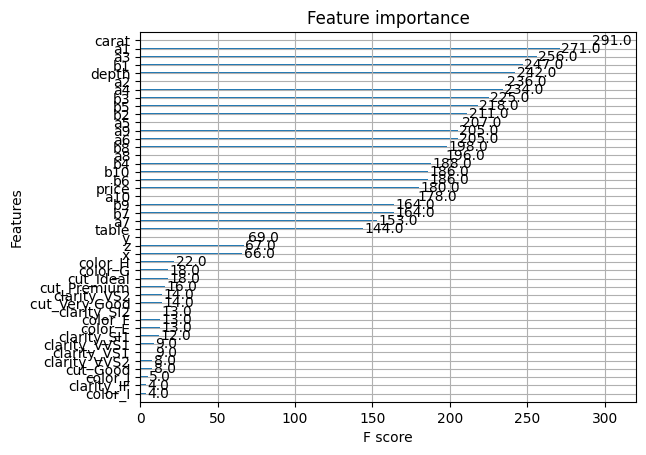

In [39]:
X, y = ds.drop(columns='outcome'), ds['outcome']
model = XGBRegressor()
model.fit(X, y)

# plot the feature importance ranking of each variable
plot_importance(model)
pyplot.show()

In [41]:
# Get and sort the feature thresholds 
thresholds = np.sort(model.feature_importances_)

# Define dictionary to store R2 scores and features 
xg_feat_dict = { 'featnum': [], 'mean_test_score': [], 'mean_train_score': [], 'feat_set': []}

# As we are using the default model no need to specify any parameters. 
param = {}

for thresh in thresholds:
    # Select all features that are within the set threshold to create our feature subset
    selection = SelectFromModel(model, threshold=thresh, prefit=True)
    selection.feature_names_in_ = X.columns.to_numpy()
    selected_X = selection.transform(X)
    
    # K-fold cross valiation 
    gsearch = GridSearchCV(estimator = XGBRegressor(), 
    param_grid = param, scoring='r2',n_jobs=4, cv=10, return_train_score=True)
    gsearch.fit(selected_X, y)

    # Log information to console 
    print(f"number of feats: {selected_X.shape[1]}")
    print(gsearch.best_params_, gsearch.best_score_, gsearch.scorer_)
    print(f"mean test score {(gsearch.cv_results_['mean_test_score'])}")
    print(f"mean train score {(gsearch.cv_results_['mean_train_score'])}")
    print(gsearch.cv_results_)
    print('\n')

    # Store features and scores in dictionary 
    xg_feat_dict['featnum'].append(selected_X.shape[1])
    xg_feat_dict['mean_test_score'].append((gsearch.cv_results_['mean_test_score']))
    xg_feat_dict['mean_train_score'].append((gsearch.cv_results_['mean_train_score']))
    xg_feat_dict['feat_set'].append(selection.get_feature_names_out())

xg_feat_df = pd.DataFrame(data=xg_feat_dict)


number of feats: 44
{} 0.39736664860411514 make_scorer(r2_score, response_method='predict')
mean test score [0.39736665]
mean train score [0.89973488]
{'mean_fit_time': array([1.2391506]), 'std_fit_time': array([0.28614323]), 'mean_score_time': array([0.00545647]), 'std_score_time': array([0.00068938]), 'params': [{}], 'split0_test_score': array([0.38884071]), 'split1_test_score': array([0.38833855]), 'split2_test_score': array([0.41063937]), 'split3_test_score': array([0.38564457]), 'split4_test_score': array([0.43483035]), 'split5_test_score': array([0.41527315]), 'split6_test_score': array([0.38790154]), 'split7_test_score': array([0.43495205]), 'split8_test_score': array([0.33380396]), 'split9_test_score': array([0.39344224]), 'mean_test_score': array([0.39736665]), 'std_test_score': array([0.02783848]), 'rank_test_score': array([1], dtype=int32), 'split0_train_score': array([0.89806969]), 'split1_train_score': array([0.89663973]), 'split2_train_score': array([0.90360738]), 'split3

In [42]:
xg_feat_df.sort_values(by="mean_test_score", ascending=False)

,featnum,mean_test_score,mean_train_score,feat_set
36,8,[0.4164198359239534],[0.8079964524489999],"[depth, a1, a3, a4, b1, b3, cut_Ideal, color_G]"
31,13,[0.4139172809258154],[0.8277486329753072],"[depth, x, y, a1, a3, a4, b1, b3, cut_Ideal, c..."
35,9,[0.41390069596916385],[0.8092473496908728],"[depth, a1, a3, a4, b1, b3, cut_Ideal, color_G..."
21,23,[0.41320716950675784],[0.8712680885466787],"[depth, price, x, y, z, a1, a3, a4, b1, b2, b3..."
33,11,[0.4116796195788025],[0.8112007239695608],"[depth, a1, a3, a4, b1, b3, cut_Ideal, color_G..."
34,10,[0.4108068693465984],[0.8099175213402884],"[depth, a1, a3, a4, b1, b3, cut_Ideal, color_G..."
37,7,[0.41059629599974273],[0.8069496402741798],"[depth, a1, a3, a4, b1, b3, color_G]"
27,17,[0.40866449520786485],[0.8492173874237242],"[depth, x, y, z, a1, a3, a4, b1, b3, b6, b8, c..."
29,15,[0.407963006973188],[0.8278485643838744],"[depth, x, y, z, a1, a3, a4, b1, b3, cut_Ideal..."
30,14,[0.40679028980420895],[0.8294532796465403],"[depth, x, y, z, a1, a3, a4, b1, b3, cut_Ideal..."


# Conclusion 

Even though feature selection with XGBoost Feature importance ranked the highest. I will be utilising the feature subset achieved from RFE. This is due to the fact that the XGBoost feature importance is said to be unreliable. Even though Carat had the highest feature importance value it did not appear in any of the top feature subset; further attesting to the unreliability of the measurement. 10 features chosen by RFE could also allow better generalisation than the 8 features chosen through XGBoost feature importance. 

Overall it is up to hyperparameter tuning. But it was interesting to notice that all top selected feature subsets from all methods all had chosen these variables: 'depth', 'a1', 'a3', and 'b1'. 


